Starting heuristic benchmark...

Testing depth 1...
Coin Parity: 0.0094s

Testing depth 2...
Coin Parity: 0.0322s

Testing depth 3...
Coin Parity: 0.1203s

Testing depth 4...
Coin Parity: 0.3957s

Testing depth 5...
Coin Parity: 2.8842s


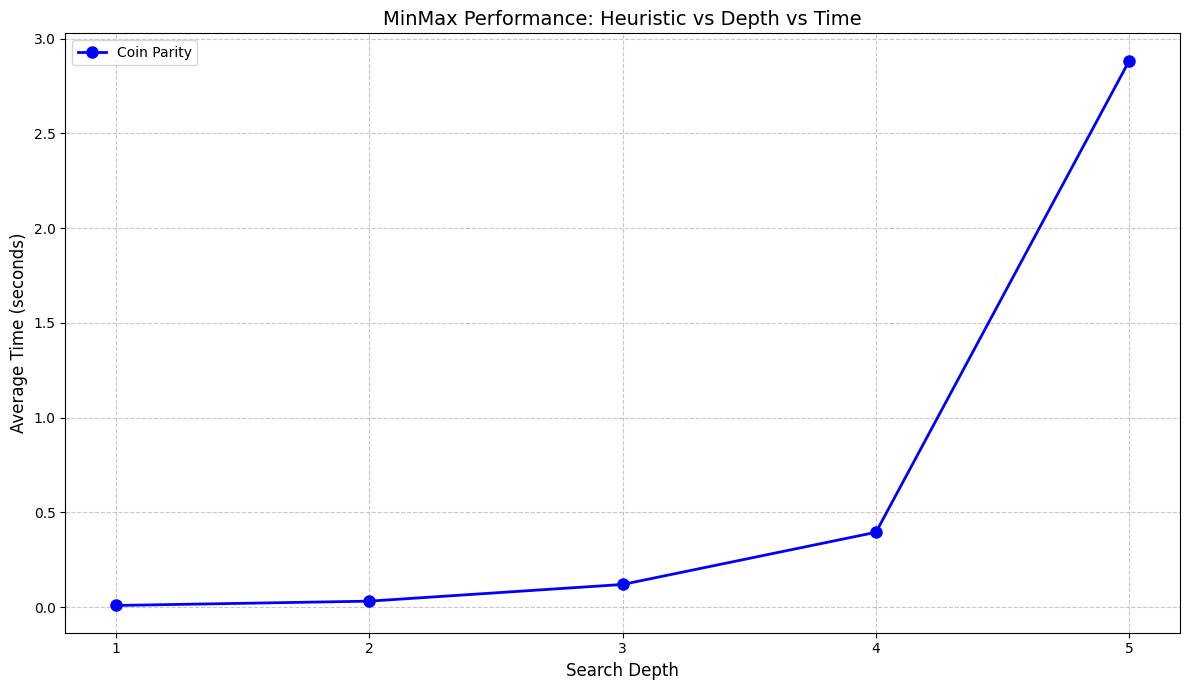

Benchmark completed. Results saved to 'heuristic_comparison.png'


In [ ]:
import time
import matplotlib.pyplot as plt
from main import Othello
from minmax import MinMaxPlayer
from heuristics import (coin_parity_heuristic, mobility_heuristic, 
                       corner_heuristic, stability_heuristic, hybrid_heuristic)
from player import Player
import numpy as np
import pygame

def benchmark_heuristics(max_depth=5, trials=3):
    heuristics = [
        ("Coin Parity", coin_parity_heuristic),
        # ("Mobility", mobility_heuristic),
        # ("Corner", corner_heuristic),
        # ("Stability", stability_heuristic),
        # ("Hybrid", hybrid_heuristic)
    ]
    
    results = {name: [] for name, _ in heuristics}
    
    for depth in range(1, max_depth + 1):
        print(f"\nTesting depth {depth}...")
        for name, heuristic in heuristics:
            total_time = 0
            valid_trials = 0
            
            for _ in range(trials):
                try:
                    # Create a dummy player for the opponent
                    dummy_player = Player("random", -1)
                    
                    # Create AI player with current heuristic
                    ai_player = MinMaxPlayer(1, heuristic, depth)
                    
                    # Initialize game
                    game = Othello(ai_player, dummy_player)
                    
                    # Force a mid-game state for more meaningful benchmarks
                    # game.board = np.zeros((8, 8), dtype=int)
                    # game.board[3:5, 3:5] = [[-1, 1], [1, -1]]  # Standard opening
                    pygame.init()

                    while game.running:
                        game.draw_board()
                        current_player_obj = game.players[game.current_player]
                        if current_player_obj.player_type == 'human':
                            for event in pygame.event.get():
                                if event.type == pygame.QUIT:
                                    game.running = False
                                if event.type == pygame.MOUSEBUTTONDOWN:
                                    x, y = event.pos
                                    if y < game.cell_size * 8:
                                        move = (y // game.cell_size, x // game.cell_size)
                                        if move in game.valid_moves(game.current_player):
                                            game.apply_move(move, game.current_player)
                                            if game.valid_moves(-game.current_player):
                                                game.current_player *= -1
                        else:
                            # pygame.time.delay(500)  # AI thinking time
                            # Get a move and time it
                            start_time = time.time()
                            move = current_player_obj.get_move(game)
                            if move:
                                game.apply_move(move, game.current_player)
                                if game.valid_moves(-game.current_player):
                                    game.current_player *= -1
                            end_time = time.time()
                            
                            if move:  # Only count if we got a valid move
                                total_time += (end_time - start_time)
                                valid_trials += 1
                        
                        if game.is_game_over():
                            game.show_winner()
                            # pygame.time.delay(500)
                            game.running = False

                            
                    pygame.quit()
                
                except Exception as e:
                    print(f"Error with {name} at depth {depth}: {str(e)}")
                    continue
            
            if valid_trials > 0:
                avg_time = total_time / valid_trials
                results[name].append(avg_time)
                print(f"{name}: {avg_time:.4f}s")
            else:
                results[name].append(float('nan'))
                print(f"{name}: No valid moves recorded")
    
    return results

def plot_results(results, max_depth):
    plt.figure(figsize=(12, 7))
    
    markers = ['o', 's', '^', 'D', 'v']  # Different markers for each heuristic
    colors = ['b', 'g', 'r', 'c', 'm']   # Different colors
    
    for idx, (name, times) in enumerate(results.items()):
        depths = range(1, max_depth + 1)
        plt.plot(depths, times, 
                marker=markers[idx], 
                color=colors[idx], 
                linestyle='-',
                linewidth=2,
                markersize=8,
                label=name)
    
    plt.title('MinMax Performance: Heuristic vs Depth vs Time', fontsize=14)
    plt.xlabel('Search Depth', fontsize=12)
    plt.ylabel('Average Time (seconds)', fontsize=12)
    plt.xticks(range(1, max_depth + 1), fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Add logarithmic scale if times vary greatly
    if max(t for t_list in results.values() for t in t_list if not np.isnan(t)) > 10:
        plt.yscale('log')
        plt.ylabel('Average Time (seconds, log scale)')
    
    plt.tight_layout()
    plt.savefig('heuristic_comparison.png', dpi=300)
    plt.show()

# Run benchmark and plot
# if _name_ == "_main_":
max_depth = 5  # Start with 4 as depth 5 might take too long for complex heuristics
trials = 1     # Number of trials per heuristic/depth combination

print("Starting heuristic benchmark...")
results = benchmark_heuristics(max_depth, trials)
plot_results(results, max_depth)
print("Benchmark completed. Results saved to 'heuristic_comparison.png'")